In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.rc('figure', dpi=300)

Будем рассматривать две функции:

1. квадратичная функция
\begin{equation*}
    f(x_1, x_2) = 100 \left(x_1 - x_2\right)^2
                    + 5 \sum_{j=2}^{n}\left(1 - x_j\right)^2;
\end{equation*}
2. функция Розенброка
\begin{equation*}
    f(x_1, x_2) = 100 \left(x_2 - x_1^2\right)^2
                    + 5\left(1 - x_1\right)^2.
\end{equation*}

In [2]:
def quadratic(*args):
    return (100 * (args[0] - args[1])**2
            + 5 * sum((1 - xi)**2 for xi in args[1:]))

def quadratic_derivatives(*args):
    derivatives = [
        200 * (args[0] - args[1]),
        -200 * (args[0] - args[1]) - 10 * (1 - args[1])
    ]
    return derivatives + [-10 * (1 - xi) for xi in args[2:]]

def rosenbrock(x1, x2):
    return 100 * (x2 - x1**2)**2 + 5 * (1 - x1)**2

def rosenbrock_derivatives(x1, x2):
    t = x2 - x1**2
    df_dx1 = -400 * x1 * t + 5 * (x1 - 1)
    df_dx2 = 200 * t
    return [df_dx1, df_dx2]

Построим их графики:

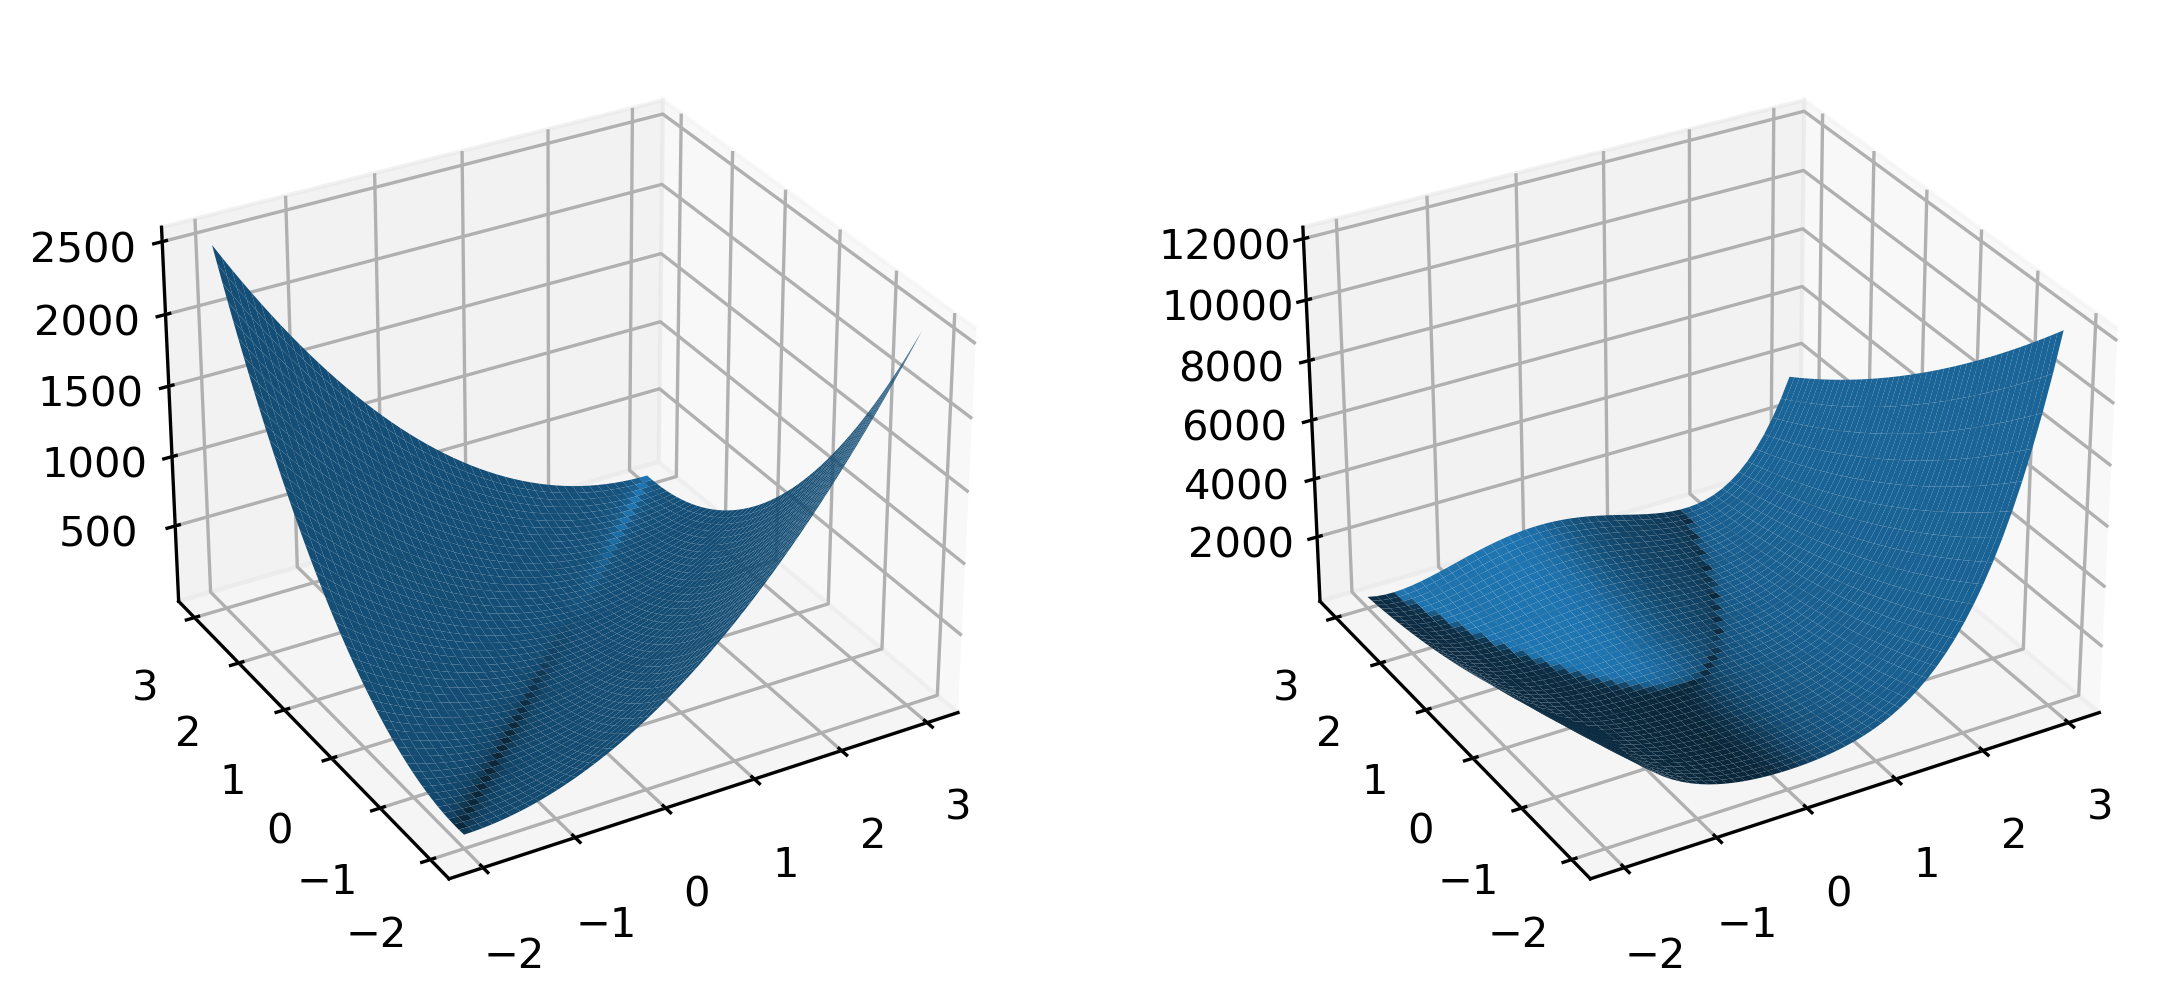

In [3]:
mesh = np.meshgrid(np.linspace(-2, 3), np.linspace(-2, 3))
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(121, projection='3d', azim=-120)
ax.plot_surface(*mesh, quadratic(*mesh))
ax2 = fig.add_subplot(122, projection='3d', azim=-120)
ax2.plot_surface(*mesh, rosenbrock(*mesh))

Далее реализуем метод градиентного спуска для поиска минимума. На каждой итерации этого метода текущее решение $\vec{x}$ обновляется по формуле
\begin{equation*}
    \vec{x} \leftarrow \vec{x} - h \nabla f(\vec{x}).
\end{equation*}

Значение параметра $h$ может выбираться тремя способами:
1. $h = \text{argmin}{f(\vec{x} - h \nabla \vec{x})}$,
2. $h = \text{const}$,
3. $\alpha \langle \nabla f(\vec{x}_k), \vec{x}_{k+1} - \vec{x}_k \rangle \leqslant f(\vec{x}_k) - f(\vec{x}_{k+1}) \leqslant \beta \langle \nabla f(\vec{x}_k), \vec{x}_{k+1} - \vec{x}_k \rangle$,
где $\vec{x}_{k+1}$$ = \vec{x}_k - h \nabla f(\vec{x}_k)$.

В первом случае для минимизации используется метод золотого сечения. Из-за этого может возникать следующая проблема: минимизируемая функция от $h$ может иметь несколько локальных минимумов, а метод золотого сечения найдёт один из них, который может не являться глобальным. Более того, найденное значение $h$ может привести к увеличению значения в новой точке, т.е. $f(\vec{x} + h \nabla f(\vec{x})) > f(\vec{x})$. Поэтому после поиска $h$ мы дополнительно проверяем это условие. Если оно выполняется, то мы ищем новое (меньшее) значение $h$ на интервале $[0, h]$ (вместо изначального $[0, 1]$).

In [4]:
def golden_section_search(f, a, b, atol=None):
    """
    Найти минимум функции `f` на интервале [`a`, `b`] с точностью `atol`
    методом золотого сечения. Точность по умолчанию `1e-4 * (b - a)`.
    """
    # точность по умолчанию
    if atol is None:
        atol = (b - a) * 1e-4
    # коэффициент для разбиения отрезка
    phi = (np.sqrt(5) - 1) / 2

    # начальное разбиение
    c = b - (b - a) * phi
    f_c = f(c)
    d, f_d = None, None

    while (b - a) > atol:
        # новая точка
        if c is None:
            c = b - (b - a) * phi
            f_c = f(c)
        else:
            assert d is None
            d = a + (b - a) * phi
            f_d = f(d)

        # выбор нового интервала
        if f_c < f_d:
            b, d = d, c
            f_d = f_c
            c = None
        else:
            a, c = c, d
            f_c = f_d
            d = None

    return a + (b - a) / 2

In [5]:
def gradient_descent(f, grad_f, x0, h_method='min', grad_min=1e-4,
                     return_solutions=False):
    """
    Найти минимум функции `f` с градентом `grad_f` с помощью метода
    градиентного спуска. Параметр `h_method` определяет способ выбора
    коэффициента `h` (x <- x - h * grad_f).
    """
    x = np.array(x0, dtype='float64')  # текущее решение
    solutions = [x.copy()]             # все решения
    grad = np.array(grad_f(*x))        # градиент в текущей точке
    grad_norm = np.linalg.norm(grad)
    f_x = f(*x)

    # обновляем ответ, пока норма градиента не станет достаточно малой
    while grad_norm > grad_min:
        if h_method == 'min':
            # поиск h из условия минимума
            h = 1.0
            while True:
                h = golden_section_search(
                    lambda h: f(*(x_i - h * grad_x_i
                                for x_i, grad_x_i in zip(x, grad))),
                    a=0,
                    b=h
                )
                if f(*(x - h * grad)) < f_x:
                    break
        elif isinstance(h_method, (int, float)):
            # постоянное значение h
            h = h_method
        else:
            # поиск h через двойное неравенство
            assert len(h_method) == 2
            alpha = h_method[0]
            beta = h_method[1]
            h_min, h_max = 0, 1
            h = 1

            # двоичный поиск
            while True:
                decrease = f_x - f(*(x - grad * h))
                dot_product = grad_norm**2 * h
                if alpha * dot_product > decrease:
                    h_max = h
                elif beta * dot_product < decrease:
                    h_min = h
                else:
                    break
                h = h_min + (h_max - h_min) / 2

        x -= h * grad
        f_x = f(*x)
        grad = np.array(grad_f(*x))
        grad_norm = np.linalg.norm(grad)
        solutions.append(x.copy())

    if return_solutions:
        return solutions
    return x

Минимум обеих функций лежит в точке $x_i = 1, i \in [1, n]$. Проверим, находит ли его реализованный метод.

In [6]:
x = gradient_descent(quadratic, quadratic_derivatives, (0, 0))
print(f'Квадратичная функция / n = 2:')
print(f'x = {x}\n')

x = gradient_descent(quadratic, quadratic_derivatives, (0, 0, 0))
print(f'Квадратичная функция / n = 3:')
print(f'x = {x}\n')

x = gradient_descent(quadratic, quadratic_derivatives, (0,) * 5)
print(f'Квадратичная функция / n = 5:')
print(f'x = {x}\n')

x = gradient_descent(quadratic, quadratic_derivatives, (0,) * 10)
print(f'Квадратичная функция / n = 10:')
print(f'x = {x}\n')

x = gradient_descent(rosenbrock, rosenbrock_derivatives, (0, 0))
print('Функция Розенброка:')
print(f'x = {x}\n')

Квадратичная функция / n = 2:
x = [0.99999001 0.99999002]

Квадратичная функция / n = 3:
x = [0.99998807 0.9999882  1.        ]

Квадратичная функция / n = 5:
x = [0.99998746 0.99998765 1.         1.         1.        ]

Квадратичная функция / n = 10:
x = [0.99998714 0.99998738 1.         1.         1.         1.
 1.         1.         1.         1.        ]

Функция Розенброка:
x = [0.99995974 0.99991899]



Теперь посмотрим, сколько итераций выполняют различные реализации метода. Постоянное значение $h$ подобрано вручную, оно близко к максимальному, при котором достигается сходимость.

In [7]:
x0 = (0, 0)
sol = gradient_descent(quadratic, quadratic_derivatives, x0,
                       return_solutions=True)
print('Квадратичная функция / поиск минимума:')
print(f'x = {sol[-1]}, число итераций: {len(sol)}\n')

sol = gradient_descent(quadratic, quadratic_derivatives, x0,
                       h_method=2e-3, return_solutions=True)
print('Квадратичная функция / h = const:')
print(f'x = {sol[-1]}, число итераций: {len(sol)}\n')

sol = gradient_descent(quadratic, quadratic_derivatives, x0,
                       h_method=(0.1, 0.9), return_solutions=True)
print('Квадратичная функция / двойное неравенство:')
print(f'x = {sol[-1]}, число итераций: {len(sol)}\n')

sol = gradient_descent(rosenbrock, rosenbrock_derivatives, x0,
                       return_solutions=True)
print('Функция Розенброка / поиск минимума:')
print(f'x = {sol[-1]}, число итераций: {len(sol)}\n')

sol = gradient_descent(rosenbrock, rosenbrock_derivatives, x0,
                       h_method=2e-3, return_solutions=True)
print('Функция Розенброка / h = const:')
print(f'x = {sol[-1]}, число итераций: {len(sol)}\n')

sol = gradient_descent(rosenbrock, rosenbrock_derivatives, x0,
                       h_method=(0.1, 0.9), return_solutions=True)
print('Функция Розенброка / двойное неравенство:')
print(f'x = {sol[-1]}, число итераций: {len(sol)}\n')

Квадратичная функция / поиск минимума:
x = [0.99999001 0.99999002], число итераций: 473

Квадратичная функция / h = const:
x = [0.99998552 0.99998587], число итераций: 1125

Квадратичная функция / двойное неравенство:
x = [0.99998917 0.99998926], число итераций: 421

Функция Розенброка / поиск минимума:
x = [0.99995974 0.99991899], число итераций: 1856

Функция Розенброка / h = const:
x = [0.99995531 0.99991017], число итераций: 4422

Функция Розенброка / двойное неравенство:
x = [0.99995858 0.99991667], число итераций: 531



Text(0.5, 1.0, 'Функция Розенброка')

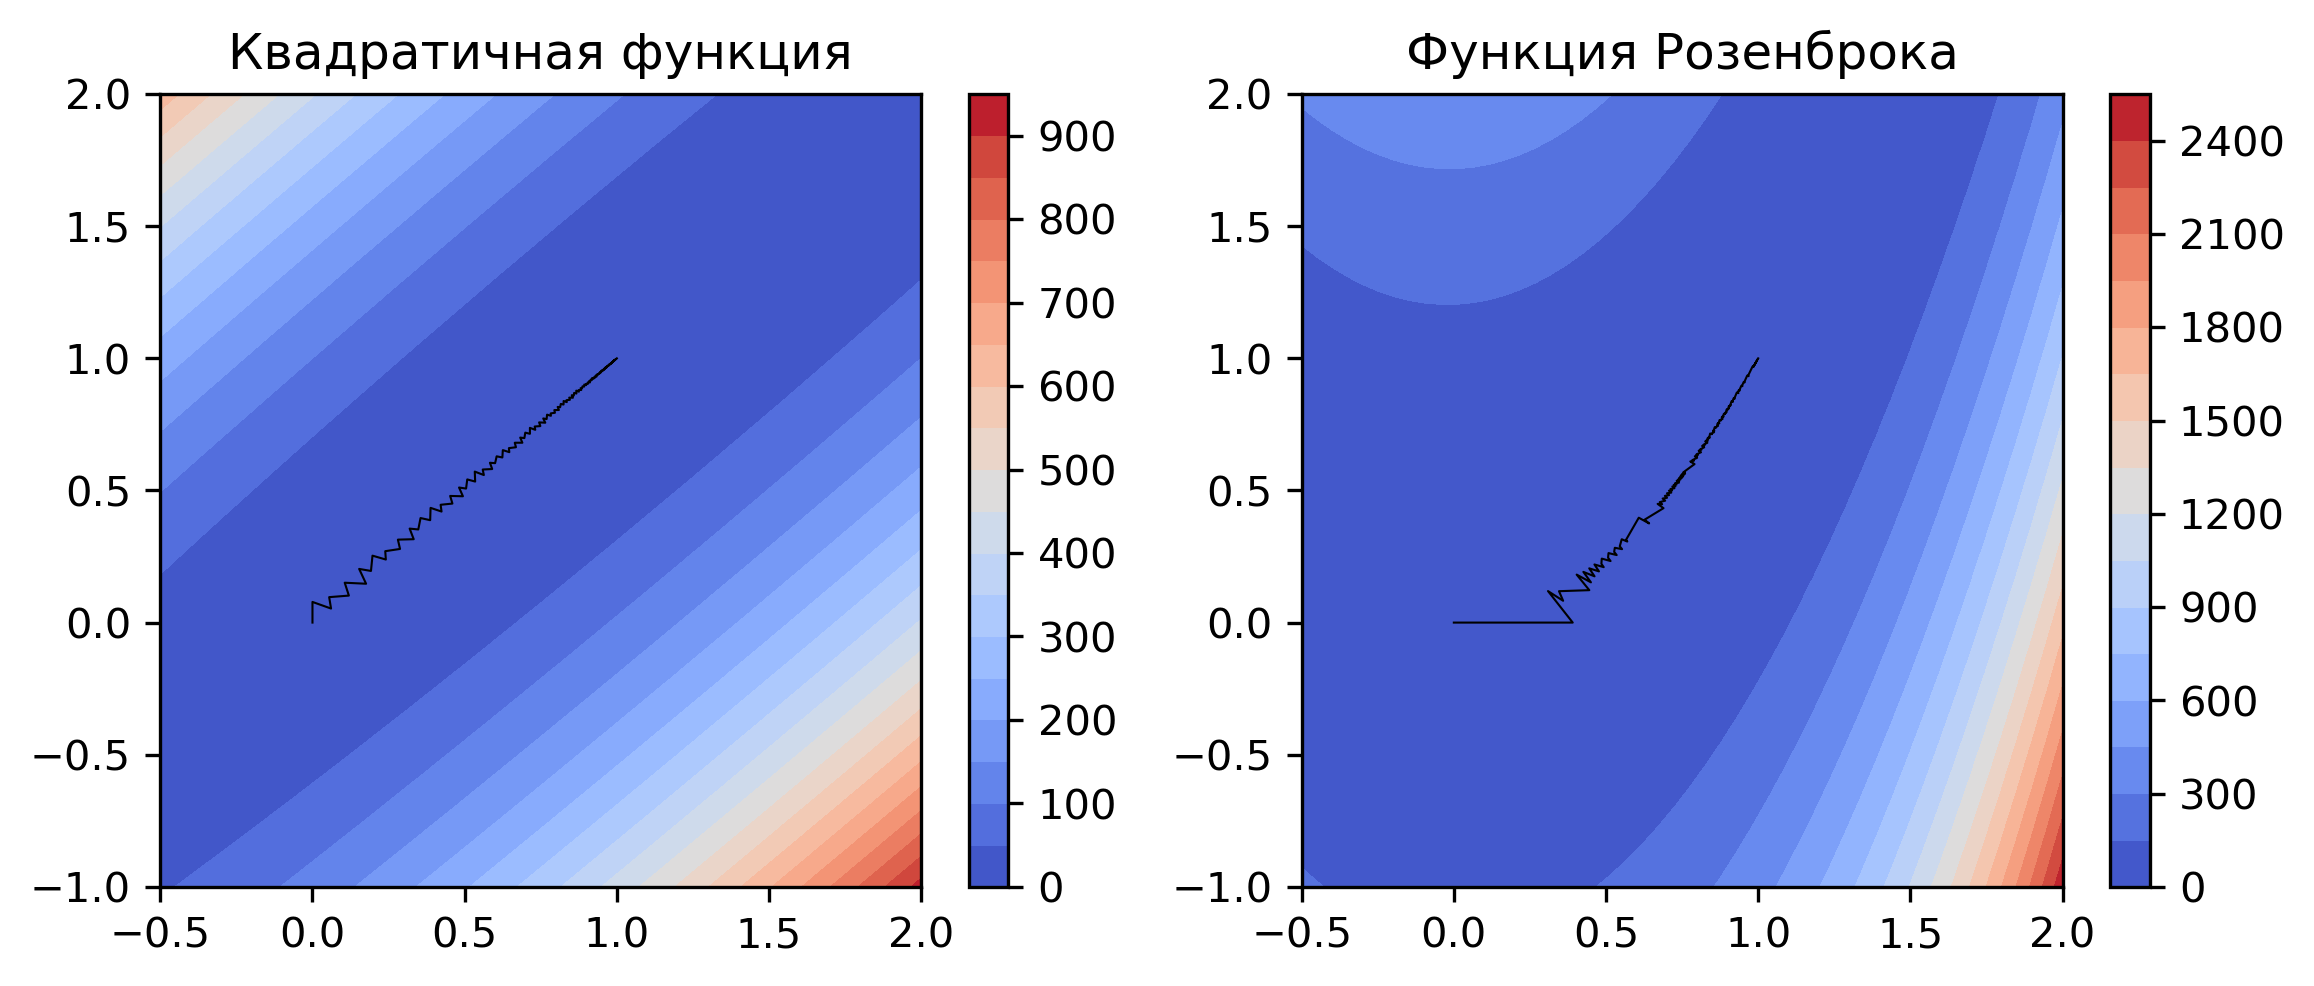

In [8]:
mesh = np.meshgrid(np.linspace(-0.5, 2), np.linspace(-1, 2))
fig, [ax1, ax2] = plt.subplots(ncols=2)
fig.set_size_inches(9, 3.5)

sol = gradient_descent(quadratic, quadratic_derivatives, x0,
                       h_method=(0.1, 0.9), return_solutions=True)
cn = ax1.contourf(*mesh, quadratic(*mesh), levels=20, cmap=plt.cm.coolwarm)
sol = np.array(sol)
ax1.plot(sol[:, 0], sol[:, 1], 'k-', lw=0.5)
fig.colorbar(cn, ax=ax1)
ax1.set_title('Квадратичная функция')

sol = gradient_descent(rosenbrock, rosenbrock_derivatives, x0,
                       h_method=(0.1, 0.9), return_solutions=True)
cn = ax2.contourf(*mesh, rosenbrock(*mesh), levels=20, cmap=plt.cm.coolwarm)
sol = np.array(sol)
ax2.plot(sol[:, 0], sol[:, 1], 'k-', lw=0.5)
fig.colorbar(cn, ax=ax2)
ax2.set_title('Функция Розенброка')